# Aula 06 - Pipeline de Machine Learning

Até o momento implementamos os seguintes algoritmos: 

- **KNN**: supervisionado, para _classificação_
- **K-means**: não-supervisionado, para _clusterização_

Estes algoritmos são simples para serem implementados, mas podemos utilizar bibliotecas prontas, como o `sklearn` (veja [o site](https://scikit-learn.org/stable/)), focando nosso trabalho na preparação e uso dos dados, bem como nas interpretações dos resultados/modelos. 

Nesta aula vamos explorar um pouco mais os métodos vistos, mas utilizando o **sklearn**.

In [1]:
# Importando a biblioteca para leitura dos dados
import pandas as pd

# Importando função para separar o dataset em TREINO e TESTE
from sklearn.model_selection import train_test_split 

# Importando os construtores dos modelos 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

# Importando as métricas a serem utilizadas
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Importando bibliotecas para visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## K-means com sklearn

### Criando os pontos

Mesma coisa que na última aula, a única diferença é que salvei os dados num DataFrame pandas, construído a partir de tuplas (`zip()`) das listas de valores para `x` e `y`. 

In [2]:
import random
random.seed(42)

n_points = 1000                                # Total de pontos
x = [random.random() for i in range(n_points)] # Variável X, com valores aleatórios entre 0 e 1
y = [random.random() for i in range(n_points)] # Variável Y, com valores aleatórios entre 0 e 1
pontos = pd.DataFrame(zip(x, y), columns=["X", "Y"])
pontos.head(5)

,X,Y
0,0.639427,0.099355
1,0.025011,0.685680
2,0.275029,0.544466
3,0.223211,0.977843
4,0.736471,0.358674


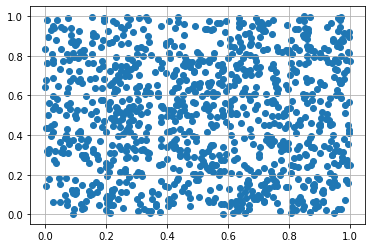

In [3]:
# Observando os pontos no espaço bidimensional 
plt.scatter(pontos['X'], pontos["Y"])
plt.grid()
plt.show()

### Escolhendo o melhor valor de K

#### Método do cotovelo

In [4]:
sse_list = []                        # lista de valores de erros quadráticos médios
for k in range(2, 11):               # para cada valor de K de 2 até 10, faça: 
    model = KMeans(n_clusters=k)     # instancie um modelo de K-means com K igual ao valor de 'k' corrente
    model.fit(pontos)                # treine o k-means usando os dados e o valor de k fornecido
    sse_list.append(model.inertia_)  # salve na lista de erros o SSE do modelo em questão (parâmetro inertia_)

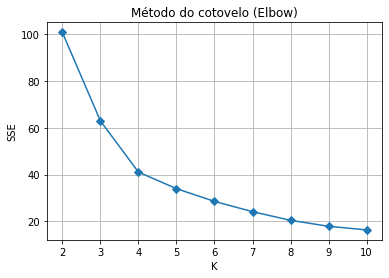

In [5]:
# Constrói o gráfico do cotevelo
plt.plot(range(2, 11), sse_list, marker="D") # Eixo X: valores de K; Eixo y: valores dos erros quadráticos médios 
plt.grid()                                   # Exiba linha de grade
plt.title("Método do cotovelo (Elbow)")      # Add um título ao gráfico
plt.xlabel("K")                              # Add um nome para o eixo x
plt.ylabel("SSE")                            # Add um nome para o eixo y
plt.show()                                   # Mostre o gráfico resultante 

#### Método da silhueta

Mesmo racional que o método do cotovelo, no entanto, nossa métrica será a silhueta que é calculada pela função importada anteriormente `silhouette_score()`, cujos parâmetros são:
- os dados
- as predições do k-means, ou seja, a informação de a qual cluster cada valor foi atribuído. Pegamos esse valor pelo parâmetro `labels_` do modelo treinado

In [6]:
silhuetas = []
for k in range(2, 11):
    model = KMeans(n_clusters=k)
    model.fit(pontos)
    score = silhouette_score(pontos, model.labels_)
    silhuetas.append(score)

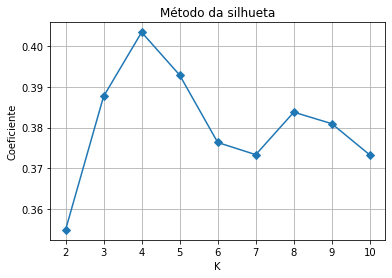

In [7]:
# Mesmo raciocínio para a construção do gráfico
plt.plot(range(2, 11), silhuetas, marker="D")
plt.grid()
plt.title("Método da silhueta")
plt.xlabel("K")
plt.ylabel("Coeficiente")
plt.show()

### Outros parâmetros do K-means

Verificar quais são na documentação do k-means, disponível [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [21]:
model = KMeans(n_clusters=3, 
               init="k-means++", #ou "random"
               max_iter=100)
model.fit(pontos)

KMeans(max_iter=100, n_clusters=3)

In [22]:
model.n_iter_ # Número de iterações necessárias para convergir 

29

In [25]:
model.cluster_centers_ # Centróides dos clusteres

array([[0.69969173, 0.22058349],
       [0.69581915, 0.75054425],
       [0.20796906, 0.50133822]])

## KNN com sklearn

### Lendo os dados

In [10]:
colunas = ["temporada", "idade", "doenças infantis", "acidente", 
           "cirurgia", "febre", "alcool", "fumo", "horas_sentado", 
           "output"]
df = pd.read_csv(r"DATASETS\fertility_Diagnosis.txt", header=None) 
df.columns = colunas

In [11]:
df.head(20)

,temporada,idade,doenças infantis,acidente,cirurgia,febre,alcool,fumo,horas_sentado,output
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,N
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,O
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,N
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,N
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,O
5,-0.33,0.67,1,0,1,0,0.8,0,0.50,N
6,-0.33,0.67,0,0,0,-1,0.8,-1,0.44,N
7,-0.33,1.00,1,1,1,0,0.6,-1,0.38,N
8,1.00,0.64,0,0,1,0,0.8,-1,0.25,N
9,1.00,0.61,1,0,0,0,1.0,-1,0.25,N


### Ajustando os dados

In [12]:
def troca_label(label):
    if label == "N":
        return 0
    else: 
        return 1

In [13]:
df["output"] = df["output"].apply(troca_label)

In [14]:
df.head(5)

,temporada,idade,doenças infantis,acidente,cirurgia,febre,alcool,fumo,horas_sentado,output
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,0
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,1
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,0
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,0
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,1


### Separando TREINO e TESTE

In [15]:
X = df.drop(columns=["output"]) # Dados
y = df["output"]                # Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Criando o modelo

In [16]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

### Avaliando o modelo

In [17]:
y_pred = knn.predict(X_test) # Para previsão das classes, útil para cálculo da Acurácia

In [18]:
accuracy_score(y_test, y_pred)

0.88

In [19]:
y_score = knn.predict_proba(X_test)  # Para previsão das probabilidades do dado pertencer a cada classe
roc_auc_score(y_test, y_score[:,-1]) # Cálculo da AUC: usa o label real e a probabilidade da classe mais alta 
                                     # (última coluna, indexada com -1)

0.5227272727272727

In [20]:
matriz_confusao = confusion_matrix(y_test, y_pred, labels=[0, 1]) # Cria a matriz de confusão
matriz_confusao

array([[22,  0],
       [ 3,  0]], dtype=int64)

<AxesSubplot:>

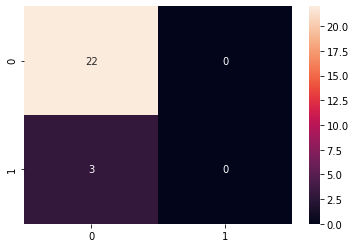

In [63]:
sns.heatmap(matriz_confusao, annot=True) # Visualiza a matriz de confusão 